<a href="https://colab.research.google.com/github/blizanac76/Reinforcement-Learning/blob/main/CartPoleSARSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cart Pole

Cart pole problem je primer matematickog klatna. U ovom scenariju, cilj je održavati ravnotezu sipke  (pole) na kolima (cart) primenom sila. Kada sipka padne ispod određenog ugla ili kada se kolica pomere izvan granica, smatra se da je sistem neuspešno kontrolisan. Sile se primenjuju horizontalno na kolica, odnosno pomeramo ih levo ili desno u cilju odrzavanja sipke uspravno.

In [ ]:
from math import pow, sin, cos
from enum import Enum
from dataclasses import dataclass
from math import radians
from random import random, uniform, choice
from numpy import arange
from abc import ABC, abstractmethod
from copy import deepcopy
from tqdm import trange


##Klasa State

In [ ]:
Action = float
class State:
    #kompletno stanje zavisi od 4 promnjive stanja: pozicije, brzine, ugaone pozicije i ugaonce brzine
    def __init__(self, x: float, x_dot: float, o: float, o_dot: float) -> None:
        self.x: float = x
        self.x_dot: float = x_dot
        self.o: float = o
        self.o_dot: float = o_dot
    # geteri za promenjive stanja zajedno
    def __getitem__(self, key: int) -> float:
        match key:
            case 0:
                return self.x
            case 1:
                return self.x_dot
            case 2:
                return self.o
            case 3:
                return self.o_dot
            case _:
                raise IndexError
    # seteri za promenjive stanja zajedno
    def __setitem__(self, key: int, value: float) -> None:
        match key:
            case 0:
                self.x = value
            case 1:
                self.x_dot = value
            case 2:
                self.o = value
            case 3:
                self.o_dot = value
            case _:
                raise IndexError

    def __repr__(self) -> str:
        return f"{self.x}, {self.x_dot}, {self.o}, {self.o_dot}"


@dataclass
class Q:
    def __init__(self, actions: list[Action]) -> None:
        self.q: dict[tuple[State, Action], float] = {}
        self.states: list[State] = []
        self.actions: list[Action] = actions

    def __iter__(self):
        return iter(self.q)
    # geter za q vrednost
    def __getitem__(self, key: tuple[State, Action]) -> float:
        if key not in self.q:
            self.q[key] = random()
            if key[0] not in self.states:
                self.states.append(key[0])
        return self.q[key]
    # seter q vednost
    def __setitem__(self, key: tuple[State, Action], value: float) -> None:
        self.q[key] = value
    #belmanova jedn.
    def determine_v(self, s: State) -> Action:
        to_max: list[tuple[Action, float]] = []
        for a in self.actions:
            if (s, a) in self.q:
                to_max.append((a, self.q[s, a]))
        return max(to_max, key=lambda x: x[1])[0] #iterira po akcijama x[1], a vraca najjvecu [0]

In [ ]:
round_prec = 3  #zaokruzivanje

##Matematicki model


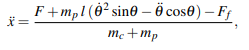

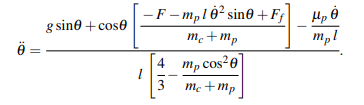

In [ ]:
g: float = 9.81
k: float = 1


class Cartpole:
    def __init__(self, m: float, M: float, L: float) -> None:
        self.m = m # sipka
        self.M = M  # kolica
        self.l = L / 2  # duzina

    def __call__(self, ss: State, a: Action, T: float) -> None:     #call daje opciju da zovemo metodu iz klase kroz ime klase kao funkciju
        #Ojler 1 : (ss_novo[0] - ss[0])/T = dss/dt = s[1]
        ss[0] = ss[0] + T * ss[1]
        ss[1] = ss[1] + T * self.F(ss, a)
        ss[2] = ss[2] + T * ss[3]
        ss[3] = ss[3] + T * self.G(ss, a)
    # kolica
    def F(self, ss: State, f: Action) -> float:
        x = ss[0]
        v = ss[1]
        o = ss[2]
        w = ss[3]

        num = 4 * f - self.m * sin(o) * (3 * g * cos(o) - 4 * self.l * pow(w, 2))
        den = 4 * (self.m + self.M) - 3 * self.m * pow(cos(o), 2)
        return num / den

        # sipka
    def G(self, ss: State, f: Action) -> float:
        x = ss[0]
        v = ss[1]
        o = ss[2]
        w = ss[3]

        num = (self.m * self.M) * g * sin(o) - cos(o) * (
            f + self.m * self.l * sin(o) * pow(w, 2)
        )
        den = self.l * (4 / 3 * (self.m + self.M) - self.m * pow(cos(o), 2))
        return num / den

##Politike

In [ ]:
class RandomPolicy:
    def act(self, q: Q, s: State) -> Action:
        return choice(q.actions)

class GreedyPolicy:
    def act(self, q: Q, s: State) -> Action:
        return max([(a, q[s, a]) for a in q.actions], key=lambda x: x[1])[0]

class EpsGreedyPolicy:
    def __init__(self, epsilon: float = 0.1) -> None:
        self.epsilon = epsilon

    def act(self, q: Q, s: State) -> Action:
        return (RandomPolicy().act(q, s) if random() < self.epsilon else GreedyPolicy().act(q, s))

##SARSA

Formula za SARSA algoritam je:


Q(s, a) = (1 - alpha)Q(s, a) + alpha * (reward + gamma * Q(s', a'))

*   Q(s,a) je trenutna vrednost Q funkcije za uredjeni par (s,a)
*   alpha je brzina ucenja, koja nam govori koliko ce jako uticati nova informacija na procenu vrednosti Q funkcije
*   reward je nagrada koje se dobija kada se iz stanja s uradi akcija a
*   gamma je faktor umenjenja koji nam govori koliko su bitne buduce nagrade
*   Q(s', a') je vrednost Q funkcije ako se u sledecem stanju s' primeni akcija a'


In [ ]:
x_threshold = 5.0
o_threshold = radians(20)

class SARSA:
    def __init__(self) -> None:
        self.ss: State | None = None
        self.result: dict[int, bool] = {}     #recnik nam se sastoji od broja iteracija i uspesnosti

    def initialize_ss(self) -> State:       #dozvojeni opseg
        return State( uniform(-x_threshold, x_threshold), 0.0, uniform(-o_threshold, o_threshold), 0.0 )

    def discretise_state(self) -> State:
        """
        Discretise the state.
        """
        return State(
            round(self.ss.x, round_prec),
            round(self.ss.x_dot, round_prec),
            round(self.ss.o, round_prec),
            round(self.ss.o_dot, round_prec),
        )

    def run(
        self,
        model: Cartpole,
        policy: EpsGreedyPolicy,
        actions: list[Action],
        gamma: float = 1.0,
        alpha: float = 0.1,
        iterations: int = 20000,
        T: float = 0.01,
    ):
        self.q = Q(actions)
        self.ss = self.initialize_ss()

        for i in trange(iterations):

            #diskretizacija pre prolsedjivanja stanja politici
            s = self.discretise_state()
            a = policy.act(self.q, s)

            model(self.ss, a, T)
            #ako je u dozvoljnom opsegu nagrada i rezultat true ako nije obrnuto
            if ( -x_threshold < self.ss[0] < x_threshold and -o_threshold < self.ss[2] < o_threshold ):
                # zbog sarse diskretizujemo i nabavljamo novo stane i novu akicju jer nam je potrebna za algoritam
                new_s = self.discretise_state()
                new_action = policy.act(self.q, new_s)
                q_plus = self.q[new_s, new_action]
                r = 10
                self.result[i] = True
            else:
                q_plus = 0.0
                r = -10
                self.ss = self.initialize_ss()
                self.result[i] = False

            self.q[s, a] = (1 - alpha) * self.q[s, a] + alpha * ( r + gamma * q_plus )
        return self.result

##Testiranje i rezultati

In [ ]:
cp = Cartpole(m=0.25, M=1, L=0.25)
T = 0.1  #Perida odabiranja
sarsa = SARSA()
rezultati = sarsa.run(
    model=cp,
    policy=EpsGreedyPolicy(epsilon=0.1),
    actions=[-5.0, 0.0, 5.0],
    gamma=0.9,
    T=T,
)
rez = [value for value in rezultati.values()]
uk_uspesni = uk_neuspesni = uspesni = neuspesni = br = br_p = it = 0
n = 1

for i in rez:
  br += 1
  br_p += 1
  if i:
    uk_uspesni += 1
    uspesni += 1
  else:
    uk_neuspesni += 1
    neuspesni += 1
  if br in [3, 9, 27, 81, 243, 729, 2187, 6561, 19683]:
    it += 1
    if br_p == br:
      print('Rezultat posle ',it,'.-ih', 2 , 'iteracija su: {:.2f}', uspesni/(uspesni+neuspesni)*100,'%')
    else:
      print('Rezultat posle ',it,'.-ih',br - br_p, 'iteracija su: {:.2f}', uspesni/(uspesni+neuspesni)*100,'%')

    uspesni = neuspesni = 0
    br_p = 0

print('################################################################')
print('Konaci rezultati su: {:.2f}',uk_uspesni/(uk_uspesni+uk_neuspesni)*100,'%')

100%|██████████| 20000/20000 [00:30<00:00, 649.98it/s]


Rezultat posle  1 .-ih 2 iteracija su: {:.2f} 100.0 %
Rezultat posle  2 .-ih 3 iteracija su: {:.2f} 66.66666666666666 %
Rezultat posle  3 .-ih 9 iteracija su: {:.2f} 66.66666666666666 %
Rezultat posle  4 .-ih 27 iteracija su: {:.2f} 70.37037037037037 %
Rezultat posle  5 .-ih 81 iteracija su: {:.2f} 74.69135802469135 %
Rezultat posle  6 .-ih 243 iteracija su: {:.2f} 70.16460905349794 %
Rezultat posle  7 .-ih 729 iteracija su: {:.2f} 72.15363511659808 %
Rezultat posle  8 .-ih 2187 iteracija su: {:.2f} 71.97073616826704 %
Rezultat posle  9 .-ih 6561 iteracija su: {:.2f} 71.37631458619113 %
################################################################
Konaci rezultati su: {:.2f} 71.555 %
